# Bidirectional LSTM (Right Wrist)

##### https://www.kaggle.com/malekzadeh/human-activity-recognition-with-mobile-sensing

##### https://github.com/akhuperkar/HAR-Smartphone-Accelerometer/blob/master/HAR%20Using%20Machine%20Learning%20.ipynb

#### Import Libraries

In [46]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import seaborn as sns
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

In [47]:
df = pd.read_csv('euler_data_right_wrist.csv')
df = df.drop([0])

In [48]:
print(df)

     PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z  \
1                1      1255232210 -20.794828  71.605827 -150.512237   
2                2      1255248877 -20.555086  71.585938 -150.417175   
3                3      1255265544 -20.665386  71.593971 -150.555023   
4                4      1255282211 -20.999645  71.611618 -150.844482   
5                5      1255298878 -21.633123  71.622208 -151.341782   
..             ...             ...        ...        ...         ...   
398            398      1261849009 -61.390083  69.506126  162.856979   
399            399      1261865676 -61.487030  69.503754  162.686813   
400            400      1261882343 -61.533802  69.505417  162.584656   
401            401      1261899010 -61.532497  69.501297  162.541519   
402            402      1261915677 -61.468365  69.500519  162.558487   

    Unnamed: 11  
1                
2                
3                
4                
5                
..          ...  
398      

In [49]:
df2 = pd.read_csv('euler_data_right_wrist_label.csv')
df2 = df2.drop([0])
print(df2)

     PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1                1      1255232210      1         NaN         NaN           
2                2      1255248877      1         NaN         NaN           
3                3      1255265544      1         NaN         NaN           
4                4      1255282211      1         NaN         NaN           
5                5      1255298878      1         NaN         NaN           
..             ...             ...    ...         ...         ...        ...
398            398      1261849009      3         NaN         NaN           
399            399      1261865676      3         NaN         NaN           
400            400      1261882343      3         NaN         NaN           
401            401      1261899010      3         NaN         NaN           
402            402      1261915677      3         NaN         NaN           

[402 rows x 6 columns]


In [50]:
df_train = df
label_train = df2
print("Shape of original data:", df_train.shape)
print("Shape of labels data:", label_train.shape)

Shape of original data: (402, 6)
Shape of labels data: (402, 6)


In [51]:
print(df_train.head())

   PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z Unnamed: 11
1              1      1255232210 -20.794828  71.605827 -150.512237            
2              2      1255248877 -20.555086  71.585938 -150.417175            
3              3      1255265544 -20.665386  71.593971 -150.555023            
4              4      1255282211 -20.999645  71.611618 -150.844482            
5              5      1255298878 -21.633123  71.622208 -151.341782            


In [52]:
def magnitude(activity):
    x2 = activity['Euler_X'] * activity['Euler_X']
    y2 = activity['Euler_Y'] * activity['Euler_Y']
    z2 = activity['Euler_Z'] * activity['Euler_Z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

df_train['m'] = magnitude(df_train)
df_train.head()

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,Unnamed: 11,m
1,1,1255232210,-20.794828,71.605827,-150.512237,,167.969500
2,2,1255248877,-20.555086,71.585938,-150.417175,,167.846313
3,3,1255265544,-20.665386,71.593971,-150.555023,,167.986815
4,4,1255282211,-20.999645,71.611618,-150.844482,,168.295178
5,5,1255298878,-21.633123,71.622208,-151.341782,,168.825553


In [53]:
print(label_train.head())

   PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1              1      1255232210      1         NaN         NaN           
2              2      1255248877      1         NaN         NaN           
3              3      1255265544      1         NaN         NaN           
4              4      1255282211      1         NaN         NaN           
5              5      1255298878      1         NaN         NaN           


In [54]:
pd.DataFrame.from_dict(Counter(label_train['Label']), orient="Index", columns=['label']).reset_index()

,index,label
0,1,121
1,2,127
2,3,154


#### Plot Acceleration Data

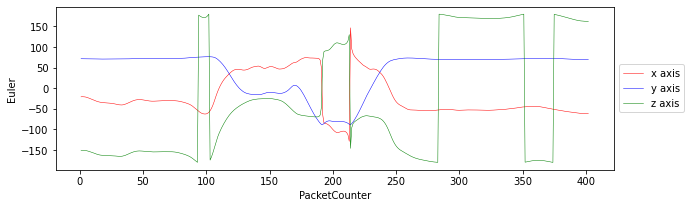

In [55]:
plt.figure(figsize=(10,3))
plt.plot(df_train['PacketCounter'], df_train['Euler_X'], linewidth=0.5, color='r', label='x axis')
plt.plot(df_train['PacketCounter'], df_train['Euler_Y'], linewidth=0.5, color='b', label='y axis')
plt.plot(df_train['PacketCounter'], df_train['Euler_Z'], linewidth=0.5, color='g', label='z axis')
plt.xlabel('PacketCounter')
plt.ylabel('Euler')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

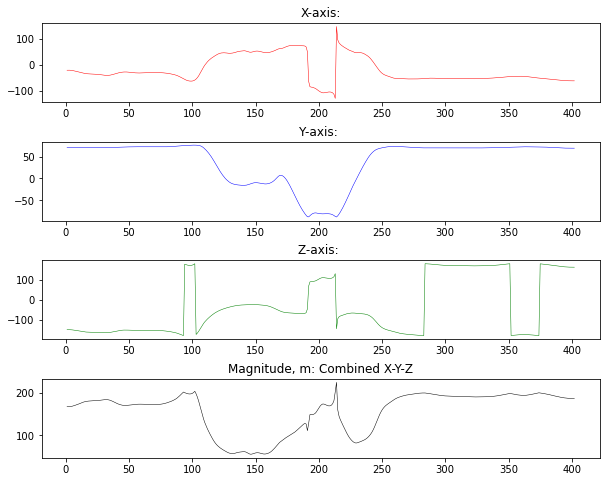

In [56]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis:')
ax[0].plot(df_train['PacketCounter'], df_train['Euler_X'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: ')
ax[1].plot(df_train['PacketCounter'], df_train['Euler_Y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: ')
ax[2].plot(df_train['PacketCounter'], df_train['Euler_Z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(df_train['PacketCounter'], df_train['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

In [57]:
# Separating data for each activity
train_df = pd.concat([df_train, label_train['Label']], axis=1).dropna()
columns = ['PacketCounter', 'Euler_X', 'Euler_Y', 'Euler_Z', 'm', 'Label']

wrist_on_elbow = train_df[columns][train_df.Label == 1]
waack = train_df[columns][train_df.Label == 2]
idle = train_df[columns][train_df.Label == 3]

In [58]:
wrist_on_elbow.head()

,PacketCounter,Euler_X,Euler_Y,Euler_Z,m,Label
1,1,-20.794828,71.605827,-150.512237,167.969500,1
2,2,-20.555086,71.585938,-150.417175,167.846313,1
3,3,-20.665386,71.593971,-150.555023,167.986815,1
4,4,-20.999645,71.611618,-150.844482,168.295178,1
5,5,-21.633123,71.622208,-151.341782,168.825553,1


In [59]:
waack.head()

,PacketCounter,Euler_X,Euler_Y,Euler_Z,m,Label
122,122,44.268368,16.094757,-52.737774,70.710695,2
123,123,45.345085,11.677794,-50.115997,68.586885,2
124,124,45.916134,7.549989,-47.717361,66.650133,2
125,125,46.061089,3.745718,-45.517563,64.865267,2
126,126,45.840145,0.310195,-43.419395,63.139995,2


In [60]:
idle.head()

,PacketCounter,Euler_X,Euler_Y,Euler_Z,m,Label
249,249,-28.052719,69.739937,-135.238998,154.726212,3
250,250,-32.399967,70.376556,-139.864716,159.889825,3
251,251,-35.878979,70.947166,-143.673065,164.203384,3
252,252,-38.551952,71.482811,-146.721283,167.699673,3
253,253,-40.662193,71.980972,-149.208160,170.580625,3


#### Plot Activity Data

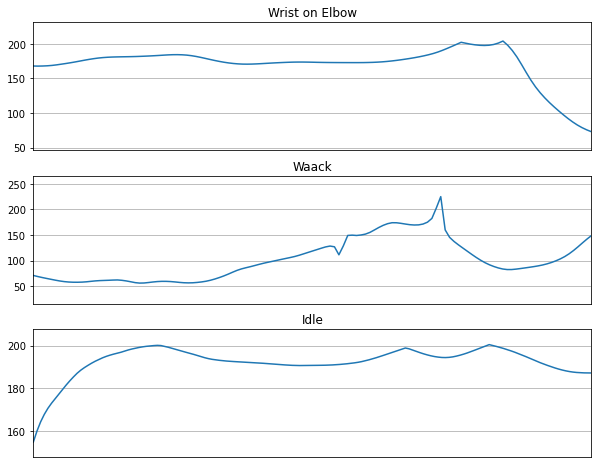

In [61]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['PacketCounter'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([wrist_on_elbow, waack, idle],
              ['Wrist on Elbow', 'Waack', 'Idle'])

#### Split training data

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_train, test_size = 0.2, random_state = 0)

In [63]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (321, 8)
y_train shape: (321, 6)


In [64]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (81, 8)
y_test shape: (81, 6)


In [65]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = label_train['Label'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300 #400 #200 #300
STEP = 150  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Euler_X', 'Euler_Y', 'Euler_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Euler_X', 'Euler_Y', 'Euler_Z']], 
    TIME_STEPS, 
    STEP
)

In [66]:
print(X_train.shape, y_train.shape)

(252, 150, 3) (252, 1)


In [67]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [68]:
print(X_train.shape, y_train.shape)

(252, 150, 3) (252, 3)


#### Train the model

In [69]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [70]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 226 samples, validate on 26 samples
Epoch 1/20
226/226 [==============================] - 4s 16ms/sample - loss: 0.9922 - acc: 0.4779 - val_loss: 1.6561 - val_acc: 0.0000e+00
Epoch 2/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.5219 - acc: 0.7965 - val_loss: 1.9353 - val_acc: 0.0000e+00
Epoch 3/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.3294 - acc: 0.9027 - val_loss: 2.0011 - val_acc: 0.0000e+00
Epoch 4/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.2430 - acc: 0.9027 - val_loss: 1.8318 - val_acc: 0.0000e+00
Epoch 5/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.1535 - acc: 0.9690 - val_loss: 1.7524 - val_acc: 0.1538
Epoch 6/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.1042 - acc: 0.9735 - val_loss: 1.8230 - val_acc: 0.1538
Epoch 7/20
226/226 [==============================] - 1s 4ms/sample - loss: 0.0907 - acc: 0.9867 - val_loss: 1.9752 - val_acc: 0.1538


#### Evaluation

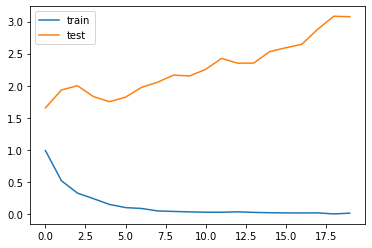

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

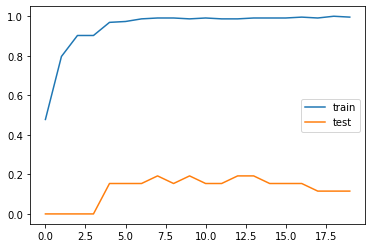

In [72]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [73]:
model.evaluate(X_test, y_test)

252/252 [==============================] - 0s 803us/sample - loss: 0.3227 - acc: 0.9087


[0.322650243692647, 0.90873015]

In [74]:
model.evaluate(X_train, y_train)

252/252 [==============================] - 0s 787us/sample - loss: 0.3227 - acc: 0.9087


[0.322650243692647, 0.90873015]

#### Confusion Matrix

In [35]:
y_pred = model.predict(X_test)

In [36]:
column_names = 'Wrist_on_Elbow', 'Waack', 'Idle'

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  #b += 0.5 # Add 0.5 to the bottom
  #t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

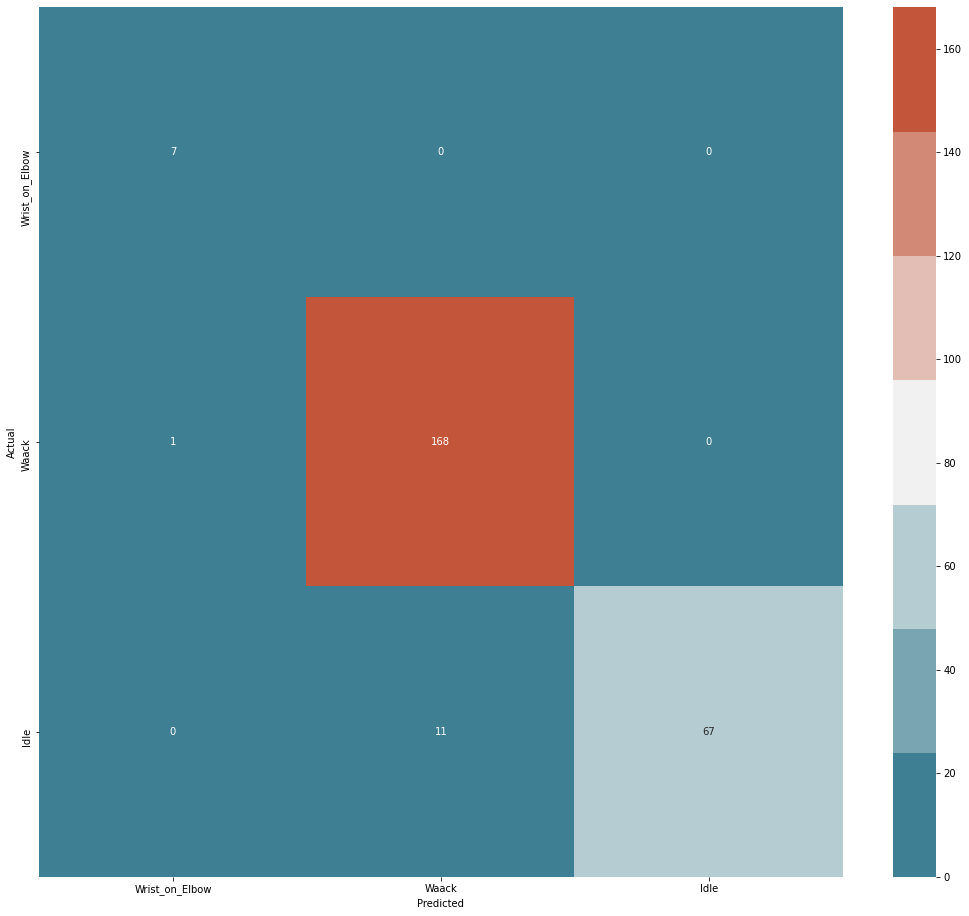

In [37]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)